In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "potato", shuffle=True, image_size=(256, 256), batch_size=32  # image
)

Found 2152 files belonging to 3 classes.


2024-05-24 10:05:40.961321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 10:05:41.139778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 10:05:41.139871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 10:05:41.143035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 10:05:41.143181: I external/local_xla/xla/stream_executor

In [3]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
len(dataset)  # number of batches in dataset

68

2024-05-24 10:05:43.451567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


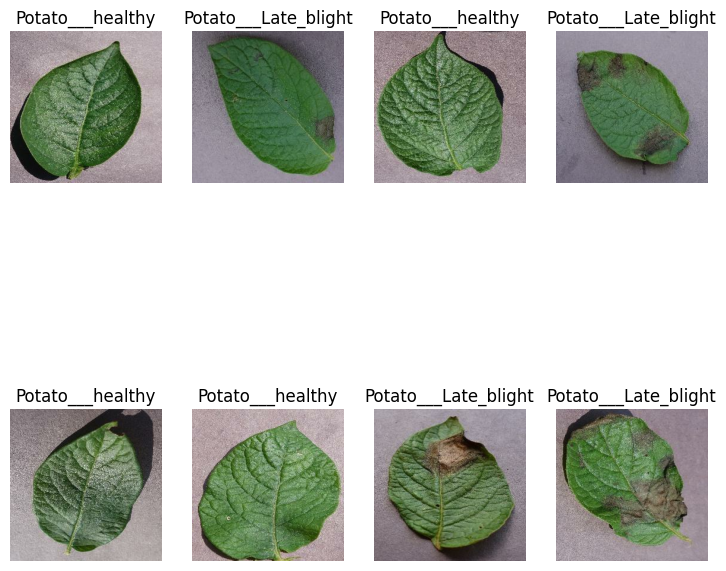

In [5]:
plt.figure(figsize=(9, 9))
for image_batch, batch_label in dataset.take(1):  # take first batch (first 32 image)
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("int"))
        plt.title(class_names[batch_label[i]])
        plt.axis("off")

## split the dataset
- train set: 80% of the data
- validation set: 10% of the data
- test set: 10% of the data

Shuffle the data before splitting it.

In [6]:
dataset = dataset.shuffle(10000, seed=12)

In [7]:
def get_dataset_partitions_tf(
    ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000
):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)  # 68
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)  # 0.8*68=54
    val_size = int(val_split * ds_size)  # 0.1*68=6
    
    train_ds = ds.take(train_size)  # 54
    val_ds = ds.skip(train_size).take(val_size)  # it will skip 54 and take 6
    test_ds = ds.skip(train_size).skip(
        val_size
    )  # it will skip 54 and skip  6 and take 8
    return train_ds, val_ds, test_ds

The cache() function is used to cache the dataset in memory. This means that once the dataset is loaded into memory during the first epoch, it will be stored so that subsequent epochs can access it faster

In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

## Data preprocessing

In [9]:
train_dataset = (
    train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Data Scaling

In [11]:
resize_and_rescale_layers = tf.keras.Sequential(
    [
        layers.Resizing(256, 256),  ## to resize the unseen images
        layers.Rescaling(1.0 / 255),  ## MinMax scaling
    ]
)

### Data Augmentation

In [12]:
augmentation_layers = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

## Model Building

### CNN Model

In [13]:
batch_size = 32
n_classes = 3
epochs = 30
build_input_shape = (batch_size, 256, 256, 3)

cnn_model = tf.keras.Sequential(
    [
        ## pre processing layers
        resize_and_rescale_layers,
        augmentation_layers,
        ## feature extraction layers (Conv2D + Maxpolling2D)
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), activation="relu", input_shape=(256, 256, 3)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        ## classification layers (fully connected layers)
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

cnn_model.build(input_shape=build_input_shape)

/home/abdelrahman/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
cnn_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [16]:
cnn_history = cnn_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs,
)

Epoch 1/30


2024-05-24 10:05:49.124647: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.4768 - loss: 0.9572 - val_accuracy: 0.4583 - val_loss: 0.8813
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6448 - loss: 0.7743 - val_accuracy: 0.8490 - val_loss: 0.4854
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7671 - loss: 0.5710 - val_accuracy: 0.7812 - val_loss: 0.4650
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8655 - loss: 0.3710 - val_accuracy: 0.8385 - val_loss: 0.3474
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9212 - loss: 0.2037 - val_accuracy: 0.7656 - val_loss: 0.6963
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9051 - loss: 0.2310 - val_accuracy: 0.8698 - val_loss: 0.2922
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9442 - loss: 0.1594 - val_accuracy: 0.9740 - val_loss: 0.0722
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9256 - loss: 0.2050 - val_accuracy: 0.9219 - val_loss: 

In [17]:
cnn_score = cnn_model.evaluate(test_dataset)

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9609 - loss: 0.1183

2024-05-24 10:08:40.707414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9672 - loss: 0.1026


In [18]:
cnn_score

[0.07679808139801025, 0.9765625]

In [19]:
cnn_history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [20]:
cnn_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

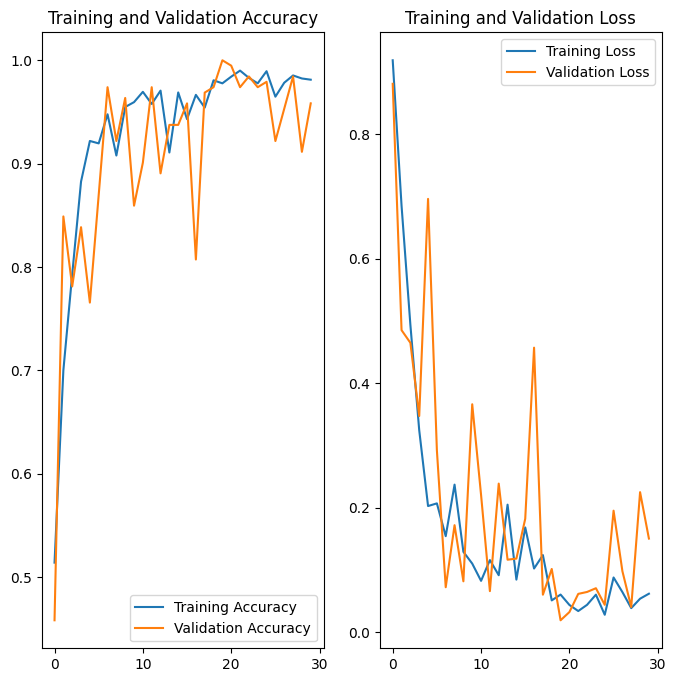

In [21]:
train_acc = cnn_history.history["accuracy"]
val_acc = cnn_history.history["val_accuracy"]

train_loss = cnn_history.history["loss"]
val_loss = cnn_history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_acc, label="Training Accuracy")
plt.plot(range(epochs), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label="Training Loss")
plt.plot(range(epochs), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

#### Making predictions

In [22]:
def predict(model, image_batch):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    # add a batch_size dimension
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)  ## predictions[0] ex: [0.1,0.5,0.4]

    predicted_class = np.argmax(predictions[0])
    confidence = round((np.max(predictions[0])) * 100, 2)

    return predicted_class, confidence

2024-05-24 10:08:41.587965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2024-05-24 10:08:43.420302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


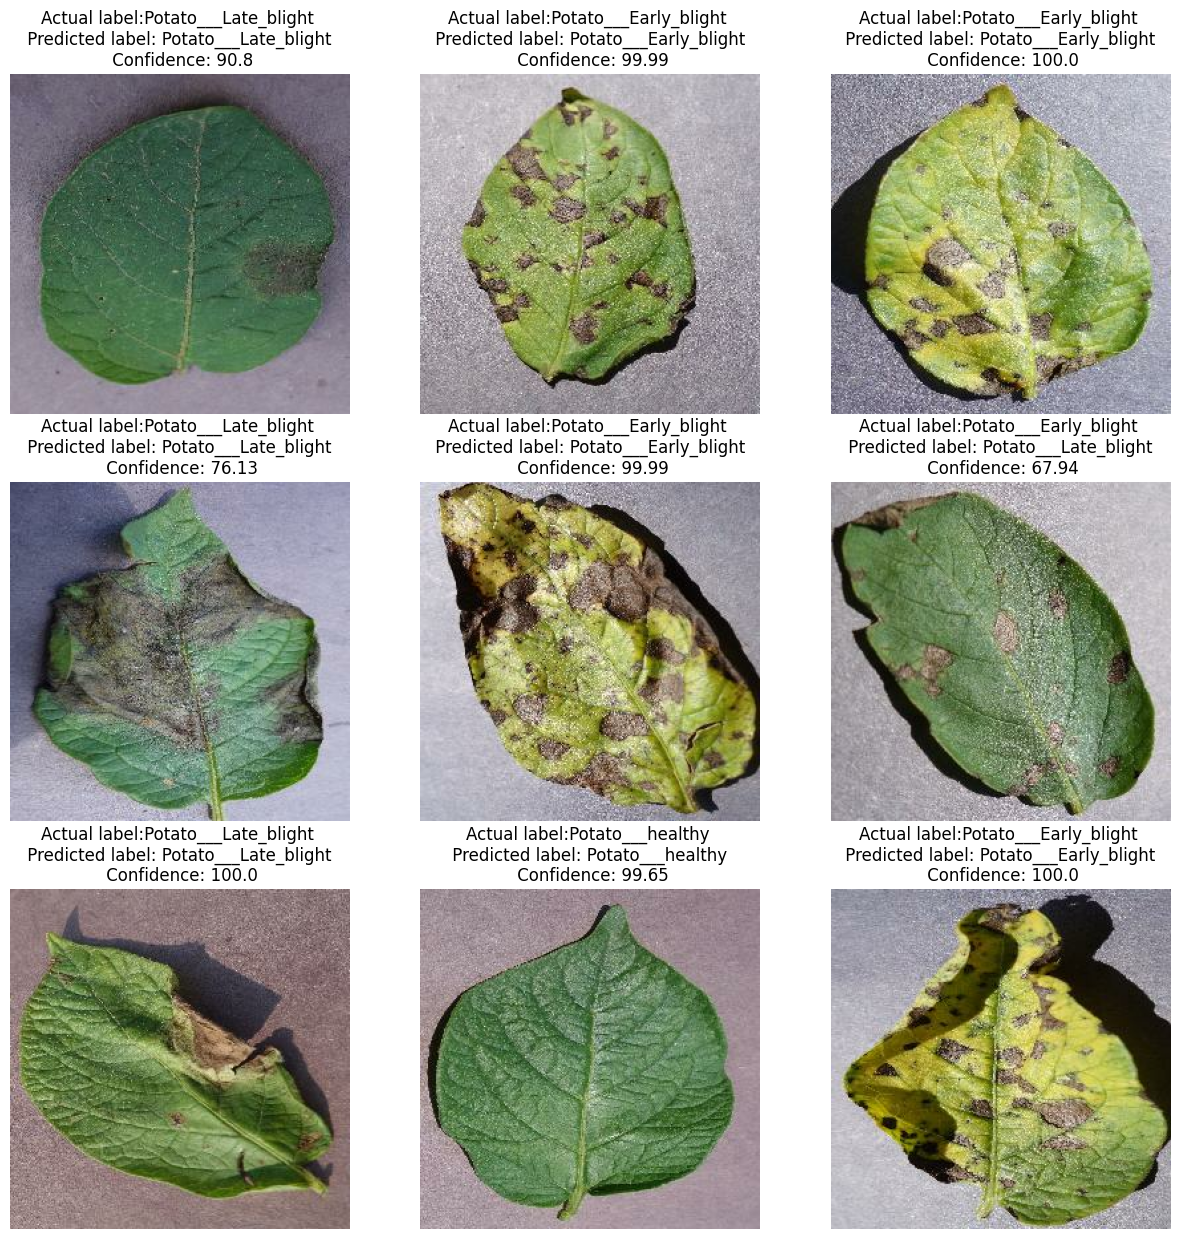

In [23]:
plt.figure(figsize=(15, 15))
for image_batch, batch_label in dataset.take(1):  # take first batch (first 32 image)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(image_batch[i].numpy().astype("int"))
        predicted_class, confidence = predict(cnn_model, image_batch)
        plt.title(
            f"Actual label:{class_names[batch_label[i]]} \n Predicted label: {class_names[predicted_class]} \n Confidence: {confidence}"
        )

        plt.axis("off")

In [48]:
cnn_predicted_labels = []
actual_labels = []
for image_batch, batch_label in test_dataset:  # take first batch (first 32 image)
    for i in range(batch_size):

        predicted_class = predict(cnn_model, image_batch)[0]

        actual_labels.append(batch_label[i])
        cnn_predicted_labels.append(predicted_class)

cnn_predicted_labels = np.array(cnn_predicted_labels)
actual_labels = np.array(actual_labels)

print(actual_labels.shape)
print(cnn_predicted_labels.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

2024-05-24 10:28:18.540971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


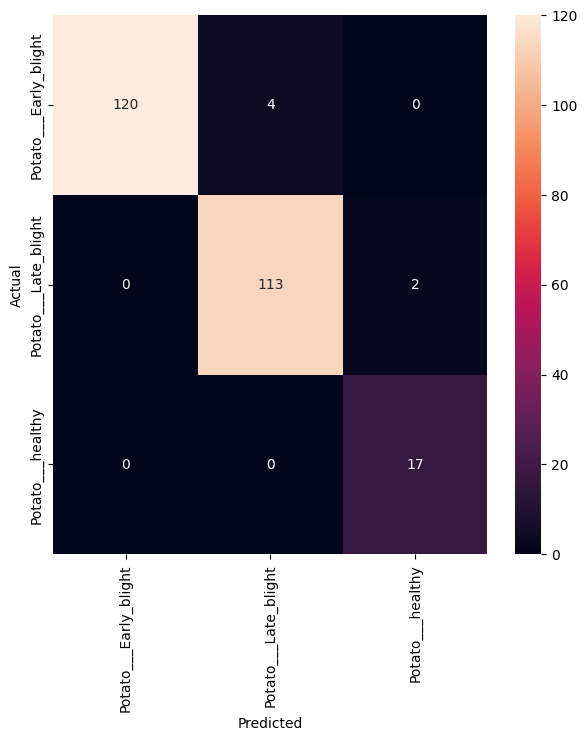

In [49]:
plt.figure(figsize=(7, 7))
cnn_cm = tf.math.confusion_matrix(
    labels=actual_labels, predictions=cnn_predicted_labels
)

sns.heatmap(
    cnn_cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
print(classification_report(actual_labels,cnn_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       124
           1       0.97      0.98      0.97       115
           2       0.89      1.00      0.94        17

    accuracy                           0.98       256
   macro avg       0.95      0.98      0.97       256
weighted avg       0.98      0.98      0.98       256



In [26]:
from tensorflow.keras.applications import ResNet152  # type: ignore
from tensorflow.keras.applications.vgg19 import VGG19  # type: ignore
from tensorflow.keras.models import Model  # type: ignore

### ResNet model

In [27]:
epochs_transfer = 15

In [28]:
## load Resnet152 model without classification layers (top layers)
resnet_base_model = ResNet152(
    include_top=False, weights="imagenet", input_shape=(256, 256, 3)
)
resnet_base_model_output = resnet_base_model.output

## add Global average polling layer
resnet_base_model_output = layers.GlobalAveragePooling2D()(resnet_base_model_output)
## add fully connected layer
resnet_base_model_output = layers.Dense(1024, activation="relu")(
    resnet_base_model_output
)
## add output layer (prediction layer)
resnet_prediction_layer = layers.Dense(n_classes, activation="softmax")(
    resnet_base_model_output
)
##final model
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_prediction_layer)
## train only the top layers (which were randomly initialized)
## freez all convolution layers
for layer in resnet_base_model.layers:
    layer.trainable = False

In [29]:
resnet_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [30]:
resnet_history = resnet_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs_transfer,
)

Epoch 1/15


I0000 00:00:1716534562.222725    2353 service.cc:145] XLA service 0xafc4c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716534562.225046    2353 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-24 10:09:22.860002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716534567.121864   10459 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16373', 184 bytes spill stores, 524 bytes spill loads

I0000 00:00:1716534567.250370   10453 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16387', 380 bytes spill stores, 380 bytes spill loads

I0000 00:00:1716534567.809197   10454 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in

33/54 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.7360 - loss: 1.1119

I0000 00:00:1716534591.630934   10728 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16387', 460 bytes spill stores, 348 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 719ms/step - accuracy: 0.7904 - loss: 0.8709 - val_accuracy: 0.9792 - val_loss: 0.0624
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9847 - loss: 0.0447 - val_accuracy: 0.9792 - val_loss: 0.0472
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.9847 - loss: 0.0541 - val_accuracy: 0.9948 - val_loss: 0.0251
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 0.9948 - val_loss: 0.0268
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9948 - val_loss: 0.0183
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.9994 - loss: 0.0064 - val_accuracy: 0.9948 - val_loss: 0.0177
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.994

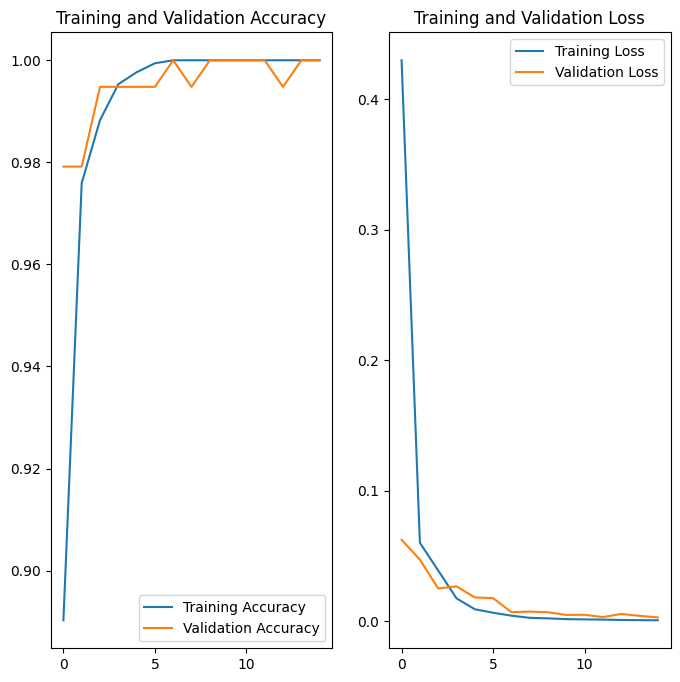

In [31]:
train_acc = resnet_history.history["accuracy"]
val_acc = resnet_history.history["val_accuracy"]

train_loss = resnet_history.history["loss"]
val_loss = resnet_history.history["val_loss"]


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_transfer), train_acc, label="Training Accuracy")
plt.plot(range(epochs_transfer), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(epochs_transfer), train_loss, label="Training Loss")
plt.plot(range(epochs_transfer), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

In [32]:
resnet_score = resnet_model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.9960 - loss: 0.0061


In [33]:
resnet_score

[0.010926490649580956, 0.9921875]

In [51]:
resnet_predicted_labels = []
actual_labels = []
for image_batch, batch_label in test_dataset:  # take first batch (first 32 image)
    for i in range(batch_size):

        predicted_class = predict(resnet_model, image_batch)[0]

        actual_labels.append(batch_label[i])
        resnet_predicted_labels.append(predicted_class)

resnet_predicted_labels = np.array(resnet_predicted_labels)
actual_labels = np.array(actual_labels)

print(actual_labels.shape)
print(resnet_predicted_labels.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

2024-05-24 10:30:08.819390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


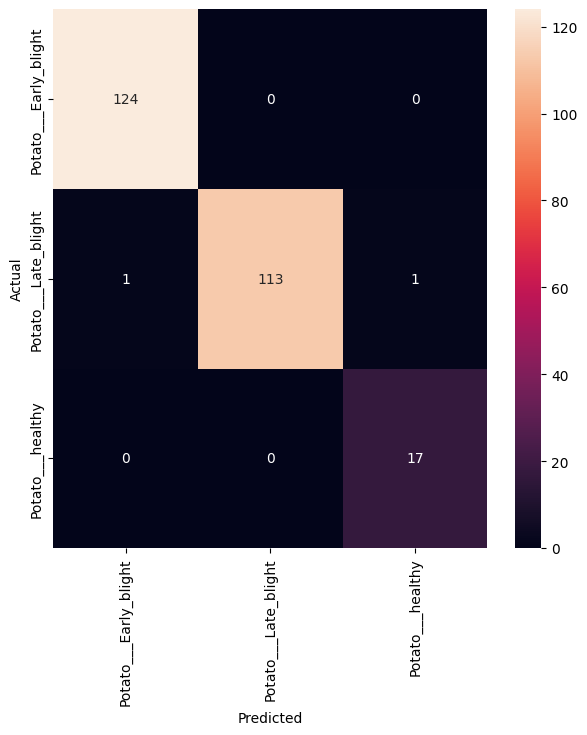

In [52]:
plt.figure(figsize=(7, 7))
resnet_cm = tf.math.confusion_matrix(
    labels=actual_labels, predictions=resnet_predicted_labels
)

sns.heatmap(
    resnet_cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
print(classification_report(actual_labels,resnet_predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       124
           1       1.00      0.98      0.99       115
           2       0.94      1.00      0.97        17

    accuracy                           0.99       256
   macro avg       0.98      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



In [36]:
resnet_model_version="resnet_model_1"
resnet_model_path=f"../saved_models/{resnet_model_version}.h5"
resnet_model.save(resnet_model_path)

### VGG model

In [37]:
## load VGG19 model without classification layers (top layers)
vgg_base_model = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
vgg_base_model_output = vgg_base_model.output

## add Flatten layer
vgg_base_model_output = layers.Flatten()(vgg_base_model_output)
## add fully connected layer
vgg_base_model_output = layers.Dense(1024, activation="relu")(vgg_base_model_output)
## add output layer (prediction layer)
vgg_prediction_layer = layers.Dense(n_classes, activation="softmax")(
    vgg_base_model_output
)

##final model
vgg_model = Model(inputs=vgg_base_model.input, outputs=vgg_prediction_layer)

## train only the top layers (which were randomly initialized)
## freez all convolution layers
for layer in vgg_base_model.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [38]:
vgg_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [39]:
vgg_history = vgg_model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=epochs_transfer,
)

Epoch 1/15


2024-05-24 10:15:49.154745: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-24 10:15:49.321393: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-24 10:15:49.495043: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-24 10:15:49.495198: W external/local_tsl/tsl/framework/bfc_

18/54 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.6172 - loss: 54.5351

2024-05-24 10:16:14.265294: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-24 10:16:14.265357: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 514ms/step - accuracy: 0.7377 - loss: 36.0337 - val_accuracy: 0.9792 - val_loss: 1.1774
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.9794 - loss: 0.6401 - val_accuracy: 0.9948 - val_loss: 0.8761
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.9830 - loss: 0.3679 - val_accuracy: 0.9740 - val_loss: 1.5657
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9891 - loss: 0.3432 - val_accuracy: 0.9896 - val_loss: 1.0980
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9932 - loss: 0.1531 - val_accuracy: 0.9844 - val_loss: 0.7881
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9896 - loss: 0.3301 - val_accuracy: 0.9948 - val_loss: 0.7218
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9948 - loss: 0.0886 - val_accuracy: 0.9948 - val_loss: 0.9386
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9990 - loss: 0.0088 - val_accuracy: 0.99

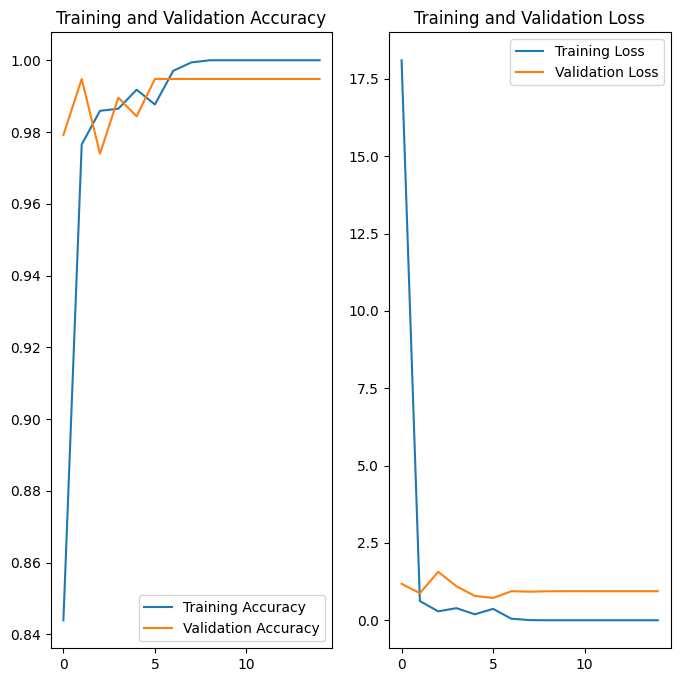

In [40]:
train_acc = vgg_history.history["accuracy"]
val_acc = vgg_history.history["val_accuracy"]

train_loss = vgg_history.history["loss"]
val_loss = vgg_history.history["val_loss"]


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_transfer), train_acc, label="Training Accuracy")
plt.plot(range(epochs_transfer), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(epochs_transfer), train_loss, label="Training Loss")
plt.plot(range(epochs_transfer), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

In [41]:
vgg_score = vgg_model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [42]:
vgg_score[1]

1.0

In [54]:
vgg_predicted_labels = []
actual_labels = []
for image_batch, batch_label in test_dataset:  # take first batch (first 32 image)
    for i in range(batch_size):

        predicted_class = predict(vgg_model, image_batch)[0]

        actual_labels.append(batch_label[i])
        vgg_predicted_labels.append(predicted_class)

vgg_predicted_labels = np.array(vgg_predicted_labels)
actual_labels = np.array(actual_labels)

print(actual_labels.shape)
print(vgg_predicted_labels.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

2024-05-24 10:31:59.131300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


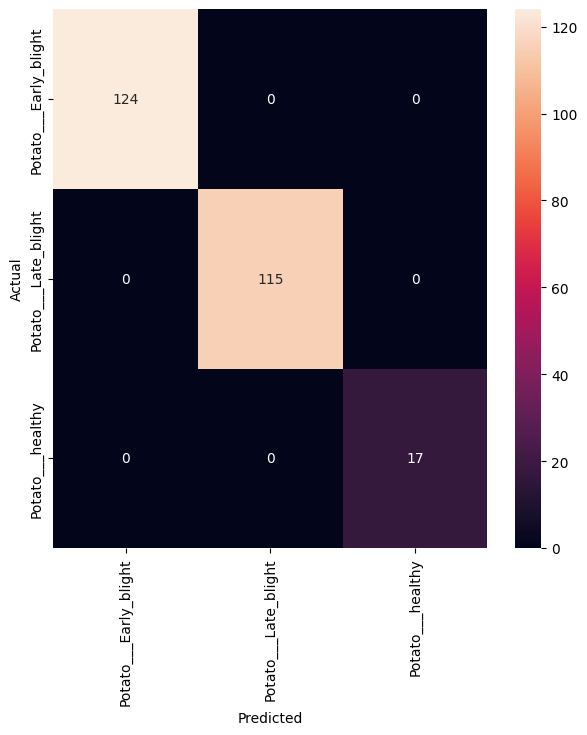

In [55]:
plt.figure(figsize=(7, 7))
vgg_cm = tf.math.confusion_matrix(
    labels=actual_labels, predictions=vgg_predicted_labels
)

sns.heatmap(
    vgg_cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
print(classification_report(actual_labels,vgg_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        17

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



## comparison

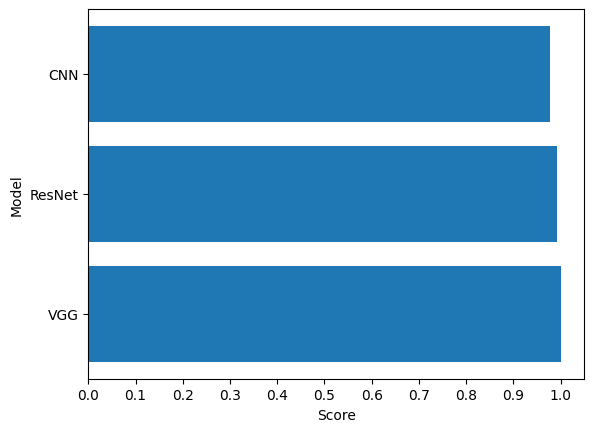

In [45]:
vgg_score_plot = vgg_score[1]
resnet_score_plot = resnet_score[1]
cnn_score_plot = cnn_score[1]

# Model names
models = ["VGG", "ResNet", "CNN"]

# Corresponding scores
scores = [vgg_score_plot, resnet_score_plot, cnn_score_plot]

# Create a bar chart
plt.barh(models, scores)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.xlabel("Score")
plt.ylabel("Model")


plt.show()